In [1]:
import torch
from torch import nn
from torch import optim
from torch.distributions import MultivariateNormal

import matplotlib.pyplot as plt

# import math
# import numpy as np
# from utils import _batch_mahalanobis

In [2]:
class GaussianParticle(nn.Module):
    def __init__(self, dim=2, mean=0, var=1):
        super().__init__()
        self.dim = dim
        self.mean = nn.parameter.Parameter(mean*torch.ones(self.dim), requires_grad=True)
        self.cov = nn.parameter.Parameter(var*torch.eye(self.dim), requires_grad=True)
        self.lmbda = nn.parameter.Parameter(torch.tensor(0.5), requires_grad=True)

    def forward(self, X):
        multivariate_normal = MultivariateNormal(loc=self.mean, covariance_matrix=self.cov)
        return torch.exp(multivariate_normal.log_prob(X))
        
        # diff = X - self.mean
        # invcov = torch.linalg.cholesky(cov)
        # M = _batch_mahalanobis(invcov, diff)
        # half_log_det = invcov.diagonal(dim1=-2, dim2=-1).log().sum(-1)
        # return torch.exp(-0.5 * (self.dim * math.log(2 * math.pi) + M) - half_log_det)

    def sample(self, nsamples=100):
        eps = torch.randn((nsamples, self.dim))
        L = torch.linalg.cholesky(self.cov)
        return self.mean + torch.matmul(eps, L)

In [3]:
def SNISLoss(samples, p, q, f):
    ps = torch.exp(p.log_prob(samples))
    qs = torch.exp(q.log_prob(samples))                                           

    r = torch.divide(ps, qs)
    w = r / r.sum()

    loss = torch.dot(w, torch.log(ps) - torch.log(f.lmbda*f(samples) + (1-f.lmbda)*qs))
    
    return loss

In [9]:
model = GaussianParticle(dim=2)

q = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.diag(2*torch.ones(2)))

p = MultivariateNormal(loc=torch.ones(2), covariance_matrix=torch.diag(0.5*torch.ones(2)))

opt = optim.SGD(model.parameters(), lr=0.001)

samples = model.sample(nsamples=1000)

losses = []

for i in range(3000):

    samples = model.sample(nsamples=100)
    loss = SNISLoss(samples, p, q, model)

    losses.append(loss.detach().numpy())

    opt.zero_grad()
    loss.backward()
    opt.step()

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 2 is not positive-definite).

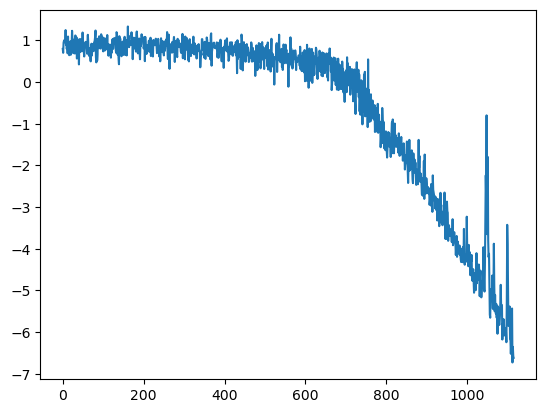

In [10]:
plt.plot(losses)
plt.show()

In [5]:
model.cov

Parameter containing:
tensor([[ 0.1417, -0.1365],
        [-0.1365,  0.6193]], requires_grad=True)